In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use("ggplot")
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [76]:
industry_data = pd.read_csv('cleaned_industry_safety_data.csv')

In [77]:
industry_data.head()

,Unnamed: 0,Accident_Level,clean_description
0,0,0,pressed while removing the drill rod the jumbo...
1,1,0,pressurized system during the activation sodiu...
2,2,0,manual tool the substation milpo located level...
3,3,0,others being 945 approximately the 1880 cx695 ...
4,4,3,others approximately 1145 circumstance that th...


In [78]:
industry_data.drop(['Unnamed: 0'],axis = 1, inplace = True)

In [79]:
industry_data.head()

,Accident_Level,clean_description
0,0,pressed while removing the drill rod the jumbo...
1,0,pressurized system during the activation sodiu...
2,0,manual tool the substation milpo located level...
3,0,others being 945 approximately the 1880 cx695 ...
4,3,others approximately 1145 circumstance that th...


In [80]:
industry_data.shape

(418, 2)

### Oversampling is required due to class imbalance problem

In [81]:
counts = industry_data['Accident_Level'].value_counts()
print(counts.index)
print(counts[0])

Int64Index([0, 1, 2, 3, 4], dtype='int64')
309


In [82]:
industry_data.reset_index(inplace = True)

In [83]:
oversample = SMOTEN()
X = np.asarray(industry_data['clean_description']).reshape(industry_data.shape[0],-1)
y = industry_data['Accident_Level']
X,y = oversample.fit_resample(X, y)

In [84]:
X.shape

(1545, 1)

In [85]:
y.shape

(1545,)

In [86]:
xdf = pd.DataFrame(X,columns = ['description'])
ydf = pd.DataFrame(y,columns = ['Accident_Level'])
industry_data = pd.concat([xdf,ydf],axis = 1)
industry_data.head()

,description,Accident_Level
0,pressed while removing the drill rod the jumbo...,0
1,pressurized system during the activation sodiu...,0
2,manual tool the substation milpo located level...,0
3,others being 945 approximately the 1880 cx695 ...,0
4,others approximately 1145 circumstance that th...,3


In [87]:
industry_data.shape

(1545, 2)

In [88]:
total_word_count = 0
for line in industry_data['description']:
    words = line.split()
    total_word_count += len(words)
print(total_word_count)

84214


In [89]:

MAX_WORDS = 75000

In [90]:
tokens = Tokenizer(num_words=MAX_WORDS, split=' ', oov_token='<OOV>')

In [91]:
pad_type = 'post' 
trunc_type = 'post'
#max_len = 500
threshold = 0.99 # to stop trainng the model once it reaches 90% accuracy
batch_size = 32
EMBEDDING_DIM=50
MAX_SEQUENCE_LENGTH = 500

In [92]:
#text = np.array(X)


In [93]:
text = np.array(industry_data['description'].values)
label = np.array(industry_data['Accident_Level'].values)
print(text[0])
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.2)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

pressed while removing the drill rod the jumbo for maintenance the supervisor proceeds loosen the support the intermediate centralizer facilitate the removal seeing this the mechanic support one end the drill the equipment pull with both hand the bar and accelerate the removal from this this moment the bar slide from it point support and tightens the finger the mechanic between the drilling bar and the beam the jumbo
(1236,) (1236,) (309,) (309,)


In [94]:
def prepare_input_data(X_train,X_test):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    tokens = Tokenizer(num_words=MAX_WORDS)
    text = np.array(text)
    tokens.fit_on_texts(text)
    text = np.array(text)
    sequences = tokens.texts_to_sequences(text)
    word_index = tokens.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]  
    vocab_size = len(tokens.word_index)
    return X_train_Glove,X_test_Glove, word_index,


In [95]:
X_train_Glove,X_test_Glove, word_index = prepare_input_data(X_train,X_test)

Found 3178 unique tokens.
(1545, 500)


In [96]:
vocab_size = len(word_index)
print(vocab_size)

3178


In [97]:
#vocab_size = total_word_count
embedding_index = dict()
file = open('glove.6B.50d.txt',encoding = 'utf8')
for line in file:
    values = line.split(' ')
    word = values[0]
    coeffs = np.asarray(values[1:],dtype = 'float32')
    embedding_index[word] = coeffs
file.close()    

In [98]:
embedding_matrix = np.zeros((vocab_size+1,50))
for word,i in tokens.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
        embedding_matrix[i] = embedding_vector
    

In [99]:
embedding_matrix.shape

(3179, 50)

In [100]:
embedding_layer = Embedding(input_dim = vocab_size+1, output_dim = EMBEDDING_DIM,weights=[embedding_matrix],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable = True)

In [101]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN,GlobalMaxPool1D,Dropout,GRU, Bidirectional, Lambda, Flatten,Input, Add,Dense,BatchNormalization
from tensorflow.keras import backend as k
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import SGD,Adam
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
opt = SGD(lr=0.01, momentum=0.9)


In [111]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(32, return_sequences = True, recurrent_dropout=0.2))
lstm_model.add(Dropout(0.5))
#lstm_model.add(LSTM(32, return_sequences = True, recurrent_dropout=0.2))
#lstm_model.add(Dropout(0.5))
#lstm_model.add(LSTM(32, return_sequences = True, recurrent_dropout=0.2))
#lstm_model.add(Dropout(0.5))
#lstm_model.add(GlobalMaxPool1D())
#lstm_model.add(LSTM(32, return_sequences = True,recurrent_dropout=0.2))
#lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(16, recurrent_dropout=0.2))
lstm_model.add(Dropout(0.5))
#lstm_model.add(Dense(256,activation = 'relu'))
lstm_model.add(Dense(5,activation = 'softmax'))
lstm_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer = 'adam',metrics = ['accuracy'])
lstm_model.summary()
#loss=tf.keras.losses.sparse_categorical_crossentropy

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 50)           158950    
                                                                 
 lstm_33 (LSTM)              (None, 500, 32)           10624     
                                                                 
 dropout_32 (Dropout)        (None, 500, 32)           0         
                                                                 
 lstm_34 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 5)                 85        
                                                                 
Total params: 172,795
Trainable params: 172,795
Non-t

In [114]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=100)
lstm_hist = lstm_model.fit(X_train_Glove, 
          y_train, 
          validation_data=[X_test_Glove, y_test],
          callbacks = [es],
          batch_size=16, 
          epochs=10
        )

Epoch 1/10
78/78 [==============================] - 74s 946ms/step - loss: 0.4029 - accuracy: 0.9183 - val_loss: 0.3368 - val_accuracy: 0.9353
Epoch 2/10
78/78 [==============================] - 73s 936ms/step - loss: 0.3352 - accuracy: 0.9353 - val_loss: 0.2935 - val_accuracy: 0.9288
Epoch 3/10
78/78 [==============================] - 72s 920ms/step - loss: 0.2751 - accuracy: 0.9498 - val_loss: 0.2993 - val_accuracy: 0.9094
Epoch 4/10
78/78 [==============================] - 71s 909ms/step - loss: 0.1909 - accuracy: 0.9676 - val_loss: 0.2932 - val_accuracy: 0.9256
Epoch 5/10
78/78 [==============================] - 72s 923ms/step - loss: 0.1715 - accuracy: 0.9684 - val_loss: 0.2723 - val_accuracy: 0.9256
Epoch 6/10
78/78 [==============================] - 70s 902ms/step - loss: 0.1299 - accuracy: 0.9846 - val_loss: 0.2943 - val_accuracy: 0.9320
Epoch 7/10
78/78 [==============================] - 74s 953ms/step - loss: 0.1873 - accuracy: 0.9660 - val_loss: 0.2779 - val_accuracy: 0.9320

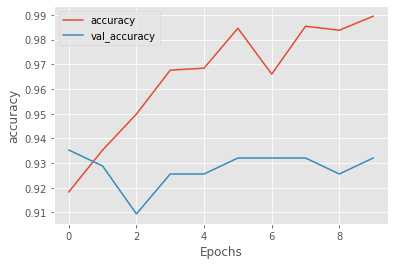

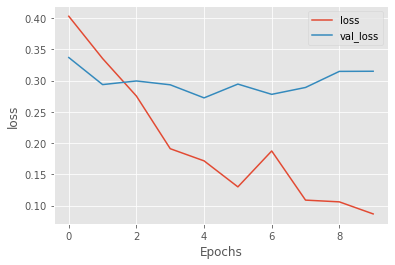

In [116]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(lstm_hist, 'accuracy')
plot_graphs(lstm_hist, 'loss')


Model Evaluation
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        68
           1       0.92      0.90      0.91        63
           2       1.00      0.90      0.95        58
           3       0.96      0.90      0.93        49
           4       1.00      1.00      1.00        71

    accuracy                           0.93       309
   macro avg       0.94      0.93      0.93       309
weighted avg       0.94      0.93      0.93       309



LSTM test Accuracy 0.9320388349514563


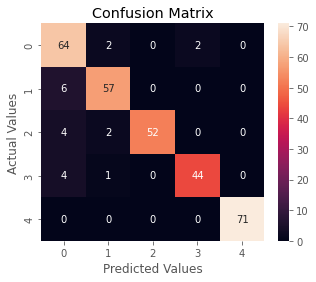

In [123]:
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,classification_report,recall_score
print("Model Evaluation")
lstm_predicted = lstm_model.predict(X_test_Glove)
lstm_predicted=np.argmax(lstm_predicted,axis=1)
print(classification_report(y_test, lstm_predicted))
print("\n")
lstm_cm = confusion_matrix(y_test, lstm_predicted)
lstm_accuracy = accuracy_score(y_test, lstm_predicted)
print("LSTM test Accuracy",lstm_accuracy)
cm_df = pd.DataFrame(lstm_cm,index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
# Confusion matrix is predicting values outside expected range
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()



In [132]:
import pickle
from keras.models import load_model
lstm_model.save('lstm_model.h5') 
#filename = "lstm_model.pkl"
#pickle.dump(lstm_model, open(filename, 'wb'))
model.save_weights('lstm_Weights')


In [138]:
loaded_model = load_model('lstm_model.h5') 
loaded_model.summary()
result = loaded_model.predict(X_test_Glove)
#savedModel = loaded_model.load_weights('lstm_Weights')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 50)           158950    
                                                                 
 lstm_33 (LSTM)              (None, 500, 32)           10624     
                                                                 
 dropout_32 (Dropout)        (None, 500, 32)           0         
                                                                 
 lstm_34 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 5)                 85        
                                                                 
Total params: 172,795
Trainable params: 172,795
Non-t

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [143]:
pred_result=np.argmax(result,axis=1)
acc_score = accuracy_score(y_test,pred_result)
print("Acc score ",acc_score)

Acc score  0.9320388349514563


### RNN model

In [144]:
rnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=50,mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5,activation = 'softmax')
])

In [145]:
rnn_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [146]:
rnn_history = rnn_model.fit(X_train_Glove, y_train, 
                    epochs=10,
                    validation_data=[X_test_Glove,y_test],
                    verbose = 1,
                    callbacks = [es],
                    
                    batch_size = 32                    
                   )

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - ETA: 0s - loss: 1.5974 - accuracy: 0.5995WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe3483d48c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


39/39 [==============================] - 27s 410ms/step - loss: 1.5974 - accuracy: 0.5995 - val_loss: 1.5844 - val_accuracy: 0.8835
Epoch 2/10
39/39 [==============================] - 19s 487ms/step - loss: 1.5672 - accuracy: 0.9021 - val_loss: 1.5445 - val_accuracy: 0.9191
Epoch 3/10
39/39 [==============================] - 19s 480ms/step - loss: 1.5072 - accuracy: 0.9167 - val_loss: 1.4533 - val_accuracy: 0.9353
Epoch 4/10
39/39 [==============================] - 20s 503ms/step - loss: 1.2822 - accuracy: 0.9102 - val_loss: 0.9421 - val_accuracy: 0.8188
Epoch 5/10
39/39 [==============================] - 18s 473ms/step - loss: 0.6270 - accuracy: 0.8697 - val_loss: 0.4961 - val_accuracy: 0.8964
Epoch 6/10
39/39 [==============================] - 20s 515ms/step - loss: 0.3631 - accuracy: 0.9167 - val_loss: 0.3400 - val_accuracy: 0.9320
Epoch 7/10
39/39 [==============================] - 19s 500ms/step - loss: 0.2751 - accuracy: 0.9272 - val_loss: 0.3106 - val_accuracy: 0.9288
Epoch 8/10

In [ ]:
filename = "rnn1_model.pkl"
pickle.dump(rnn_model, open(filename, 'wb'))

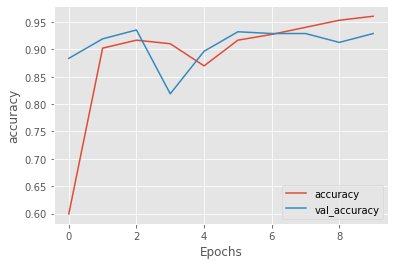

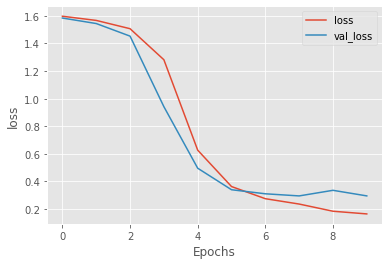

In [160]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(rnn_history, 'accuracy')
plot_graphs(rnn_history, 'loss')


RNN Model Evaluation
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        68
           1       0.98      0.89      0.93        63
           2       0.95      0.90      0.92        58
           3       0.98      0.90      0.94        49
           4       1.00      1.00      1.00        71

    accuracy                           0.93       309
   macro avg       0.94      0.92      0.93       309
weighted avg       0.94      0.93      0.93       309



LSTM test Accuracy 0.9288025889967637


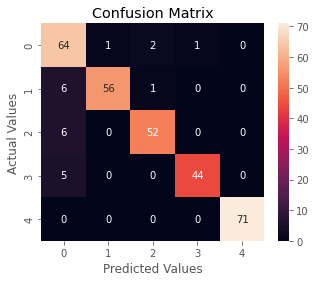

In [161]:
print("RNN Model Evaluation")
rnn_predicted = rnn_model.predict(X_test_Glove)
rnn_predicted=np.argmax(rnn_predicted,axis=1)
print(classification_report(y_test, rnn_predicted))
print("\n")
rnn_cm = confusion_matrix(y_test, rnn_predicted)
rnn_accuracy = accuracy_score(y_test, rnn_predicted)
print("LSTM test Accuracy",rnn_accuracy)
cm_df = pd.DataFrame(rnn_cm,index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
# Confusion matrix is predicting values outside expected range
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()



### GRU model 

In [147]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_size+1, emb_dim, trainable = True, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(5, activation = 'softmax'))
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 50)          158950    
                                                                 
 gru_4 (GRU)                 (None, 128)               69120     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 228,715
Trainable params: 228,715
Non-trainable params: 0
_________________________________________________________________
None


In [148]:
history = gru_model.fit(X_train_Glove, y_train, 
                        validation_data=(X_test_Glove, y_test), 
                        batch_size = 32, epochs = 5)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - ETA: 0s - loss: 1.3042 - accuracy: 0.6570WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe3b2767dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - 20s 444ms/step - loss: 1.3042 - accuracy: 0.6570 - val_loss: 0.6750 - val_accuracy: 0.7379
Epoch 2/5
39/39 [==============================] - 16s 423ms/step - loss: 0.4534 - accuracy: 0.7937 - val_loss: 0.3903 - val_accuracy: 0.8026
Epoch 3/5
39/39 [==============================] - 16s 421ms/step - loss: 0.2926 - accuracy: 0.9134 - val_loss: 0.3545 - val_accuracy: 0.8997
Epoch 4/5
39/39 [==============================] - 17s 438ms/step - loss: 0.2130 - accuracy: 0.9409 - val_loss: 0.2905 - val_accuracy: 0.9094
Epoch 5/5
39/39 [==============================] - 17s 439ms/step - loss: 0.1189 - accuracy: 0.9668 - val_loss: 0.2924 - val_accura

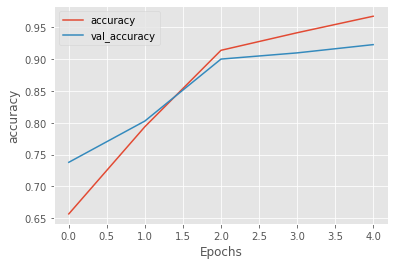

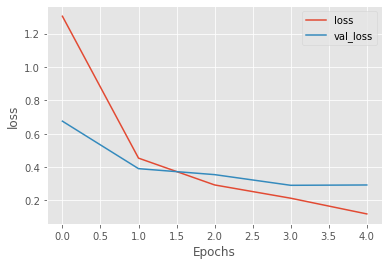

In [158]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

GRU Model Evaluation
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        68
           1       0.95      0.90      0.93        63
           2       0.93      0.90      0.91        58
           3       0.98      0.90      0.94        49
           4       0.99      1.00      0.99        71

    accuracy                           0.92       309
   macro avg       0.93      0.92      0.92       309
weighted avg       0.93      0.92      0.92       309



LSTM test Accuracy 0.9223300970873787


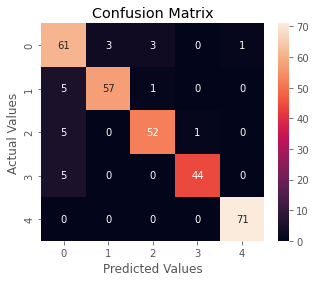

In [159]:
print("GRU Model Evaluation")
gru_predicted = gru_model.predict(X_test_Glove)
gru_predicted=np.argmax(gru_predicted,axis=1)
print(classification_report(y_test, gru_predicted))
print("\n")
gru_cm = confusion_matrix(y_test, gru_predicted)
gru_accuracy = accuracy_score(y_test, gru_predicted)
print("LSTM test Accuracy",gru_accuracy)
cm_df = pd.DataFrame(gru_cm,index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
# Confusion matrix is predicting values outside expected range
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
filename = "gru_model.pkl"
pickle.dump(gru_model, open(filename, 'wb'))

In [149]:
rn_model = Sequential()
rn_model.add(Embedding(input_dim=vocab_size+1, output_dim=50))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
rn_model.add(GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
rn_model.add(SimpleRNN(128))

rn_model.add(Dense(5, activation = 'softmax'))

rn_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 50)          158950    
                                                                 
 gru_5 (GRU)                 (None, None, 256)         236544    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_24 (Dense)            (None, 5)                 645       
                                                                 
Total params: 445,419
Trainable params: 445,419
Non-trainable params: 0
_________________________________________________________________


In [150]:
rn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [151]:
rn_history = rn_model.fit(X_train_Glove, y_train, 
                        validation_data=(X_test_Glove, y_test), 
                        batch_size = 32, epochs = 5)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - ETA: 0s - loss: 0.7679 - accuracy: 0.7508WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe40487eb90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - 45s 1s/step - loss: 0.7679 - accuracy: 0.7508 - val_loss: 0.3493 - val_accuracy: 0.9385
Epoch 2/5
39/39 [==============================] - 38s 966ms/step - loss: 0.2505 - accuracy: 0.9304 - val_loss: 0.2334 - val_accuracy: 0.9353
Epoch 3/5
39/39 [==============================] - 39s 990ms/step - loss: 0.1277 - accuracy: 0.9628 - val_loss: 0.2561 - val_accuracy: 0.9159
Epoch 4/5
39/39 [==============================] - 39s 1s/step - loss: 0.0458 - accuracy: 0.9935 - val_loss: 0.2709 - val_accuracy: 0.9223
Epoch 5/5
39/39 [==============================] - 38s 984ms/step - loss: 0.0188 - accuracy: 0.9968 - val_loss: 0.2828 - val_accuracy: 0.

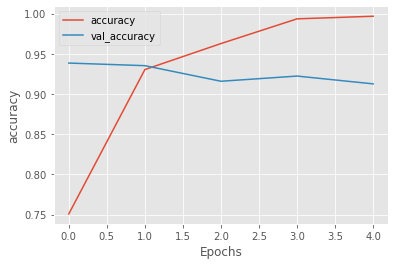

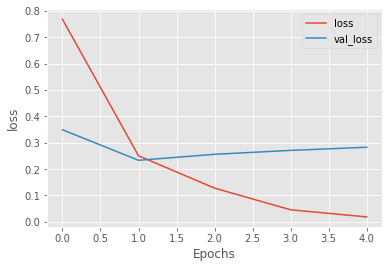

In [152]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(rn_history, 'accuracy')
plot_graphs(rn_history, 'loss')

RNN Model Evaluation
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        68
           1       0.92      0.90      0.91        63
           2       1.00      0.90      0.95        58
           3       0.96      0.90      0.93        49
           4       1.00      1.00      1.00        71

    accuracy                           0.93       309
   macro avg       0.94      0.93      0.93       309
weighted avg       0.94      0.93      0.93       309



RNN test Accuracy 0.9320388349514563


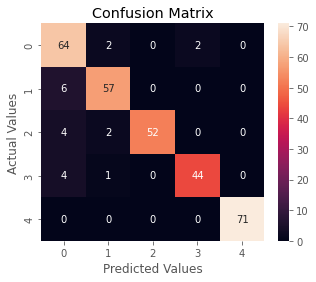

In [156]:
print("RNN Model Evaluation")
rn_predicted = lstm_model.predict(X_test_Glove)
rn_predicted=np.argmax(rn_predicted,axis=1)
print(classification_report(y_test, rn_predicted))
print("\n")
rn_cm = confusion_matrix(y_test, rn_predicted)
rn_accuracy = accuracy_score(y_test, rn_predicted)
print("RNN test Accuracy",rn_accuracy)
cm_df = pd.DataFrame(rn_cm,index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
# Confusion matrix is predicting values outside expected range
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()